## Tectonics and Landscape Evolution Class part 1



#### We are going to use our field work measurements to create our model from the Teton Fault

In [1]:
#Importing required functions 

import pandas as pd
from landlab import RasterModelGrid, imshow_grid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator, NormalFault
import numpy as np
import matplotlib.pyplot as plt
from FieldWork_class import FieldWork
from f_running_normal_fault import running_normal_fault
import rasterio
from rasterio.transform import from_origin
from time import time


The average strike is 10.0
The average dip is 58.904761904761905
Your area has 20000 km x 11250 km, the grid has 112.5 rows and 333.3333333333333 columns


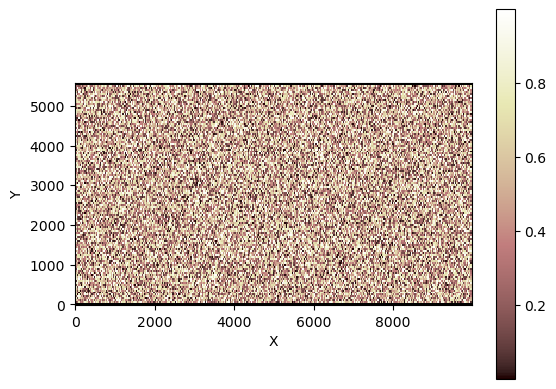

In [2]:
#Import you field work data
data = pd.read_csv('field_work_teton_park.csv')
data

#Calculate parameters for your model
fw = FieldWork(data)
result = fw.calculate_dip_strike()

#Set the size of your area
x_size = 20000 # in meters
y_size  = 11250 # in meters
dx = 60 #cell resolution in x
dy = 100 #cell resolution in y

#rows,cols = fw.calculate_grid_size(x_size,y_size,dx,dy) 

rows, cols = map(int, fw.calculate_grid_size(x_size, y_size, dx, dy))

#create basin_mg
basin_mg = RasterModelGrid((rows,cols),xy_spacing=(30,50)) #rows = y, cols = x

# Add elevation field
np.random.seed(35)
z = basin_mg.add_zeros('topographic__elevation', at='node')
z += np.random.rand(z.size)

# Set boundary conditions to match Teton

basin_mg.set_closed_boundaries_at_grid_edges(False,True,False,True) #top,left,bottom,right
imshow_grid(basin_mg, 'topographic__elevation')
# plt.show()




In [3]:
## Initialise the landscape and parameters

# Dictionary for parameter values
params  = {'stream_power': {'K_sp': 0.00006, 
                        'n_sp': 1, 
                        'm_sp': 0.3}, 
                        'diffuser': {'D_diff': 0.003}}

K_sp = params['stream_power']['K_sp']
m_sp = params['stream_power']['m_sp']
n_sp = params['stream_power']['n_sp']

## Forward model evolution

n_steps = 100001
dt = 1000  # timestep in years

U = np.ones(basin_mg.number_of_nodes)
uplift_rate = 0.000500 #in meters/years
U = U*uplift_rate

fa = FlowAccumulator(basin_mg, flow_director='D8')
ld = LinearDiffuser(basin_mg, linear_diffusivity=params['diffuser']['D_diff'])
sp = StreamPowerEroder(basin_mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)

uplift_per_steps = dt * U

#### For class purpose we are gonna load the steady state model from a txt-file

In [ ]:

def save_to_tif(grid, timestep):
    transform = from_origin(0, 0, dx, dy)
    elevation = grid.at_node['topographic__elevation'].reshape((rows, cols))
    with rasterio.open(
        f'elevation_timestep_{timestep}.tif',
        'w',
        driver='GTiff',
        height=elevation.shape[0],
        width=elevation.shape[1],
        count=1,
        dtype=elevation.dtype,
        crs='+proj=latlong',
        transform=transform,
    ) as dst:
        dst.write(elevation, 1)

def save_to_npy(grid, timestep):
    filename="elevation_timestep_"+str(timestep)+".npy"
    elevation = grid.at_node['topographic__elevation']
    np.save(filename, elevation)

start = time()       
for i in range(n_steps):

     basin_mg.at_node['topographic__elevation'][basin_mg.core_nodes] += uplift_per_steps[basin_mg.core_nodes]
     fa.run_one_step()
     sp.run_one_step(dt=dt)
     ld.run_one_step(dt)

     if i%100 == 0:
         print(f"currect time is {(time() - start)/60:.2f} mins")
         imshow_grid(basin_mg, 'topographic__elevation')
         plt.show()
         print(i)
         save_to_tif(basin_mg, i)
         save_to_npy(basin_mg, i)
end = time()
print(f"Total computation time is {(end - start)/60:.2f} mins")

In [ ]:
## save the model 

np.savetxt("model_teton_steady_state",basin_mg.at_node['topographic__elevation'])


### Setting up our fault from our steady-state model



Here we are going to use 3 different uplift rate for our faults and see the pattern of our rivers

In [1]:
##load the model 
basin_fault_mg = RasterModelGrid((rows,cols),xy_spacing=(dx,dy))
#basin_fault_mg.at_node['topographic__elevation'] = np.loadtxt("model_teton_steady_state")
basin_fault_mg.at_node['topographic__elevation'] = np.load("elevation_timestep_42100.npy")

z_f = basin_fault_mg.at_node['topographic__elevation']

basin_fault_mg.set_closed_boundaries_at_grid_edges(True,False,True,False)

imshow_grid(basin_fault_mg, 'topographic__elevation')

NameError: name 'RasterModelGrid' is not defined

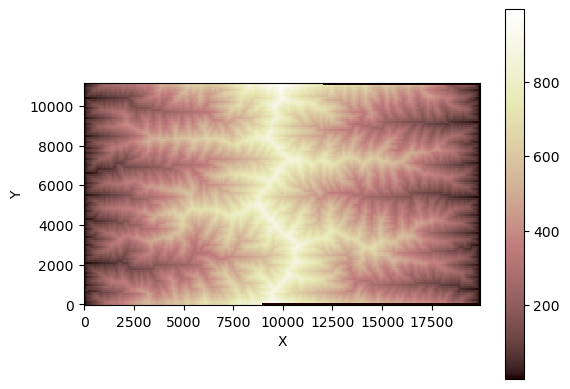

0


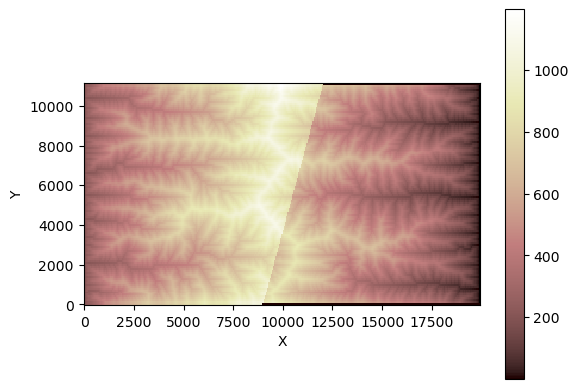

1000


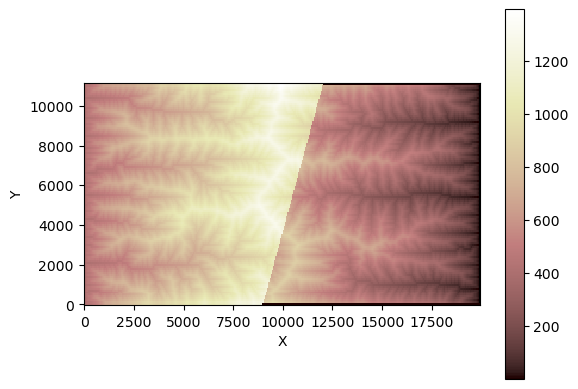

2000


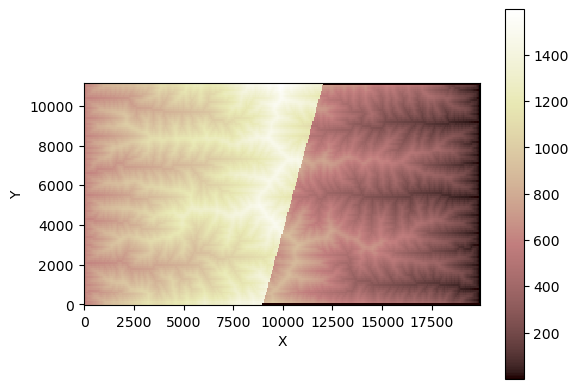

3000


In [ ]:
## Setting parameters for normal fault event
uplift_rates = np.array([0.2,0.4,0.6])/1000 #set fault uplift rate (in mm/yr)
dip_angle = 45 # this come from the measurements we took on the field trip
bottom_xy_coord = (9000,0)
top_xy_coord = (12000,11000)

for i in range (3):
    running_normal_fault(basin_fault_mg,uplift_rates,dip_angle,bottom_xy_coord,top_xy_coord,n_steps,dt,i,fa,ld,sp)